In [1]:
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.misc import imresize
from ca import CellularSpace

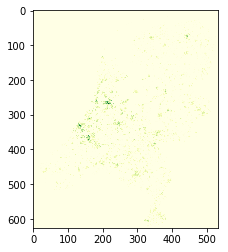

In [10]:
#The Netherlads density map
from parsepop import get_ca
density_map = np.array(get_ca('500x500data.csv'))
density_map = np.flip(density_map, axis = 0)
plt.imshow(density_map, cmap='YlGn')
plt.show()

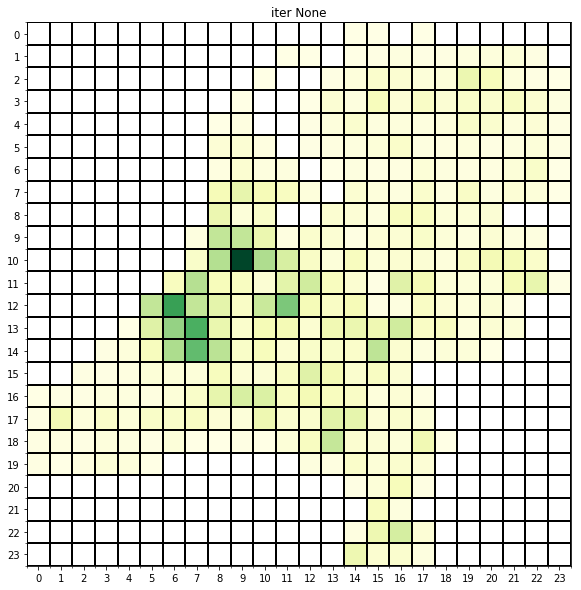

In [11]:
params = {'beta': 0.9,
              'gamma': 0.4,
              'wieght': 4,
              'time_step': 1,
              'd_inf': 5,
              'cell': (12,7)
              }

cellular_space = CellularSpace(params, x=24, y=24, density_map = density_map)
cellular_space.plot(mode = 'dm')

In [6]:
print(cellular_space.get_cell_state(params['cell']))
cellular_space.get_infection(cell = params['cell'], n_infected = 1)
print(cellular_space.get_cell_state(params['cell']))

[367.   0.   0.   0.   0.   0.   0.]
cell (12, 7) is infected
[366.   1.   0.   0.   0.   0.   0.]


In [7]:
# cellular_space.plot(mode = 'sm')

In [9]:
# cellular_space.update()
# cellular_space.plot(mode = 'sm')

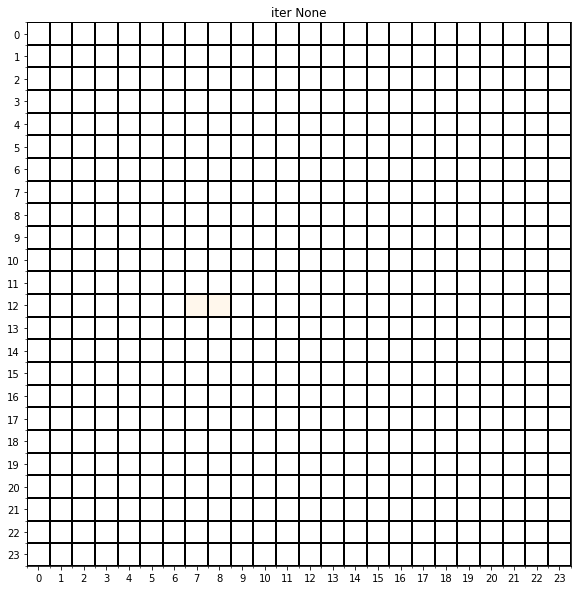

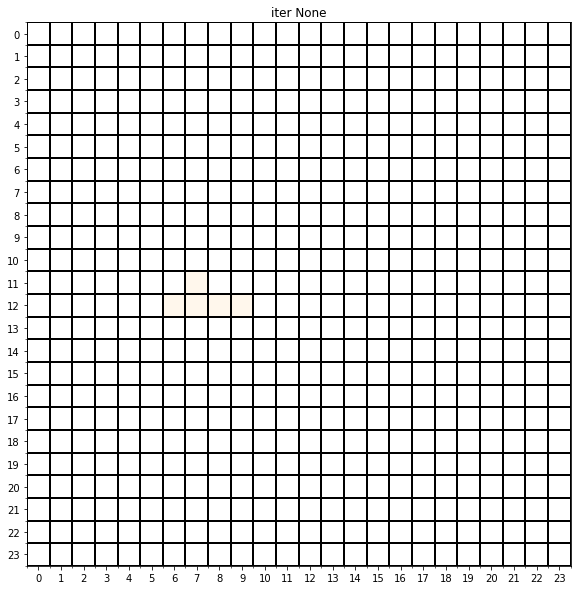

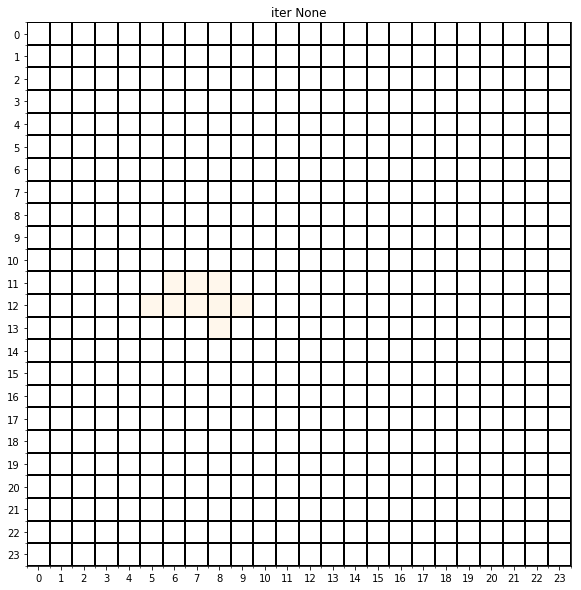

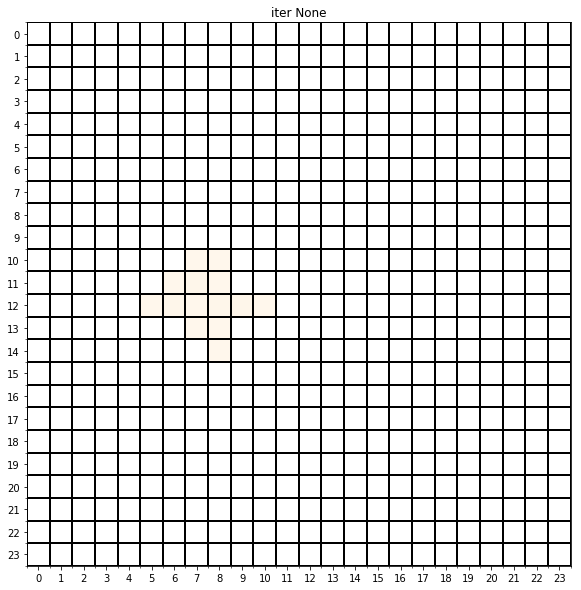

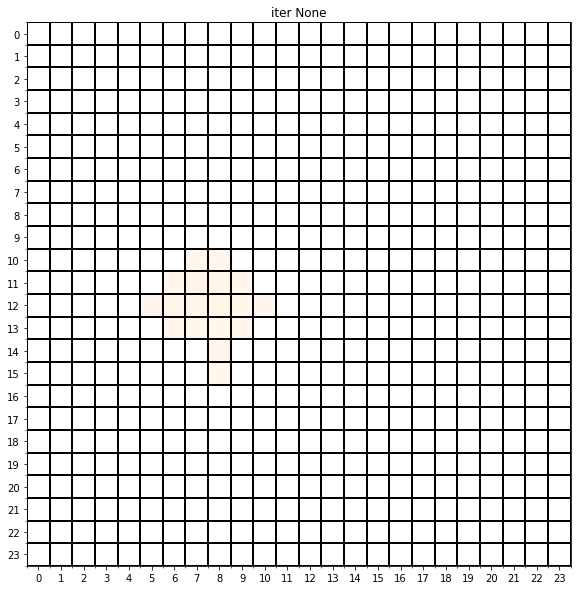

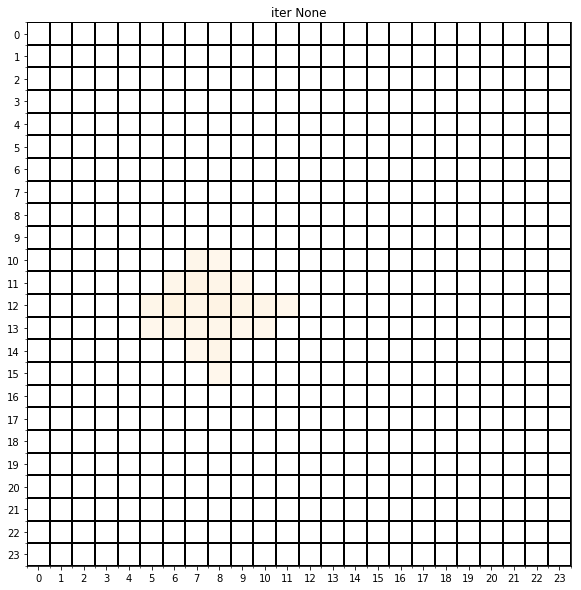

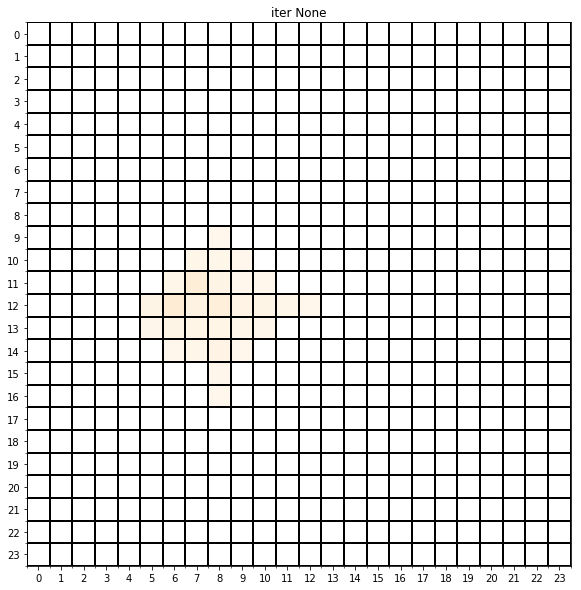

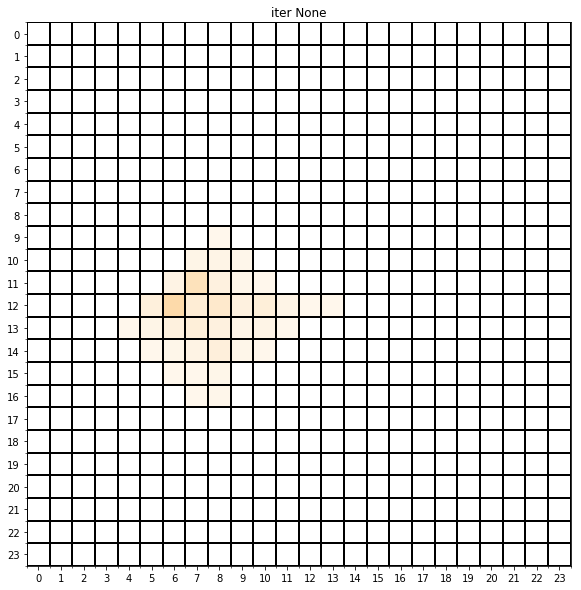

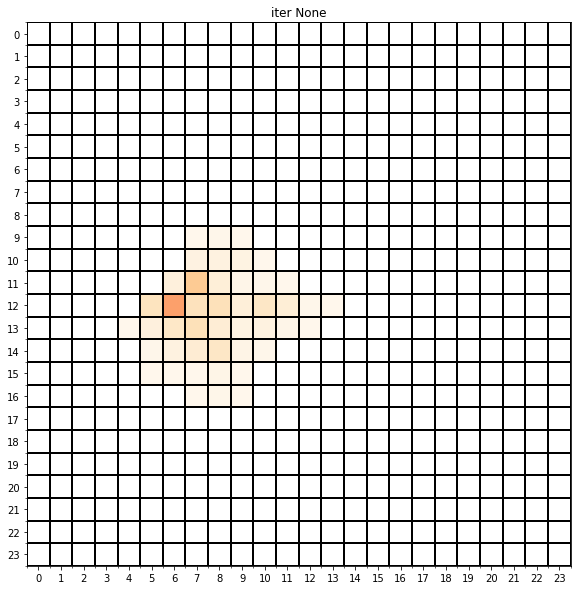

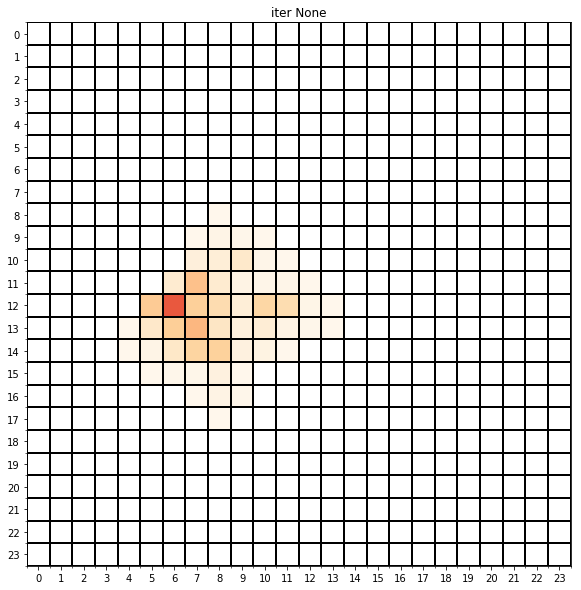

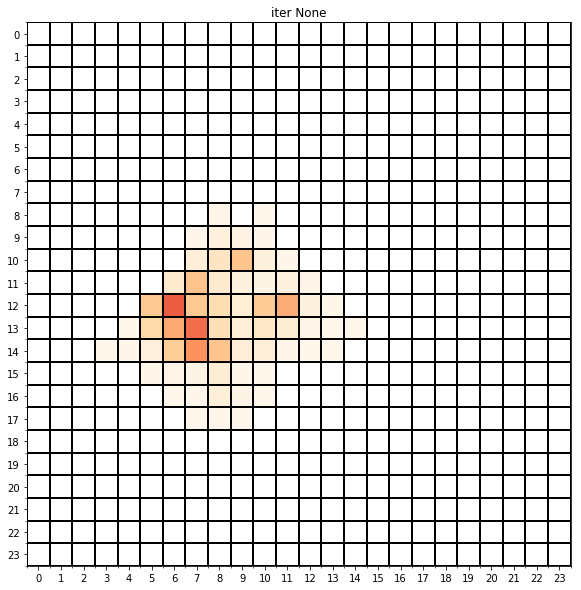

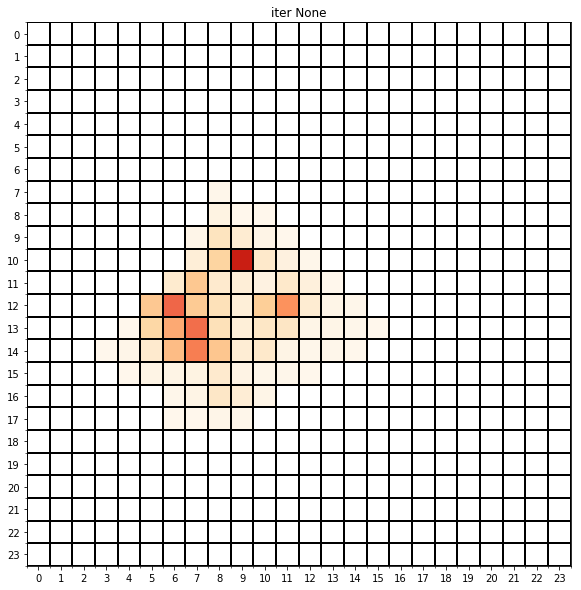

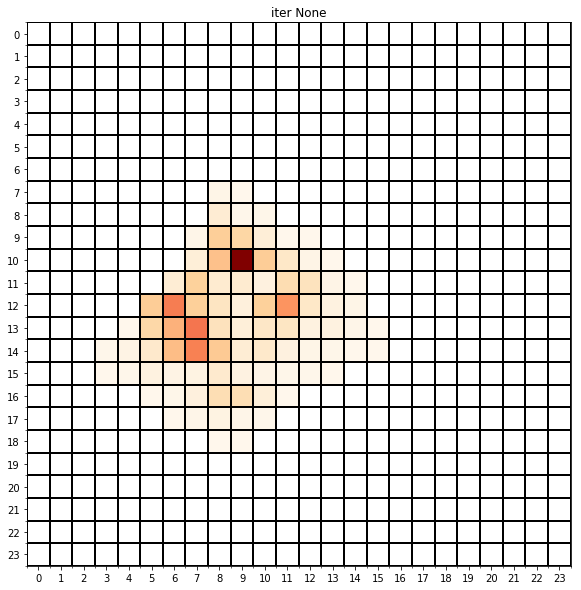

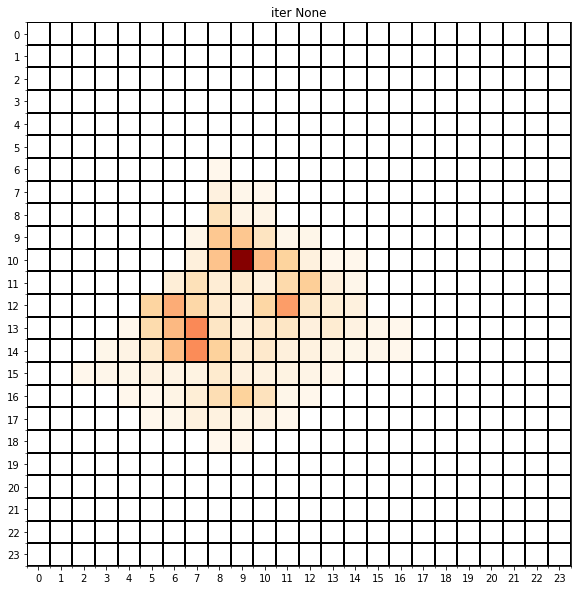

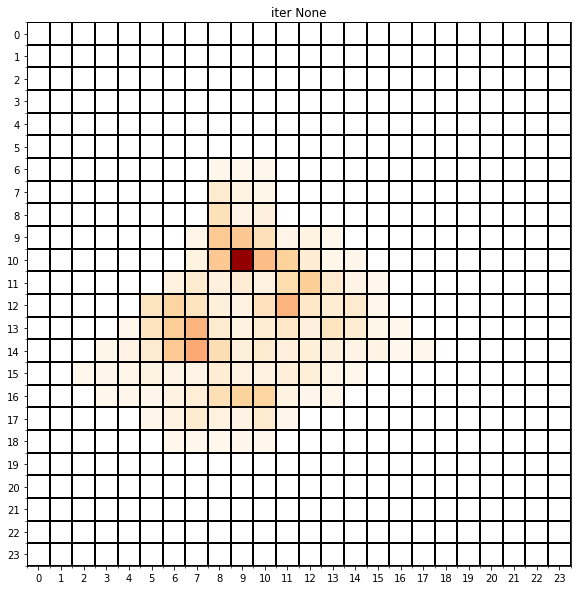

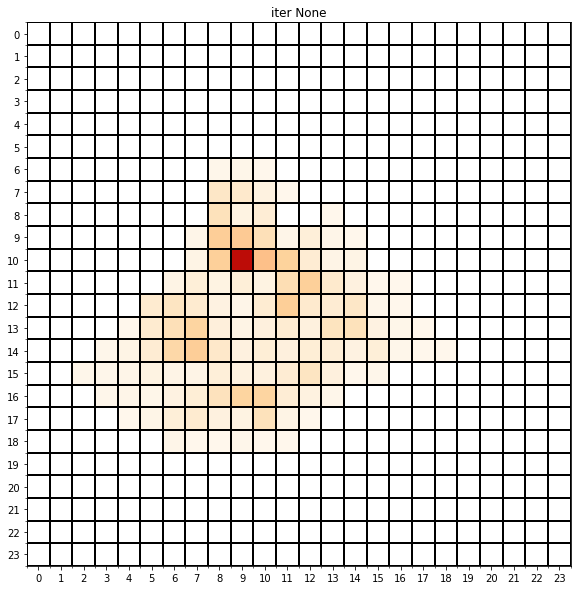

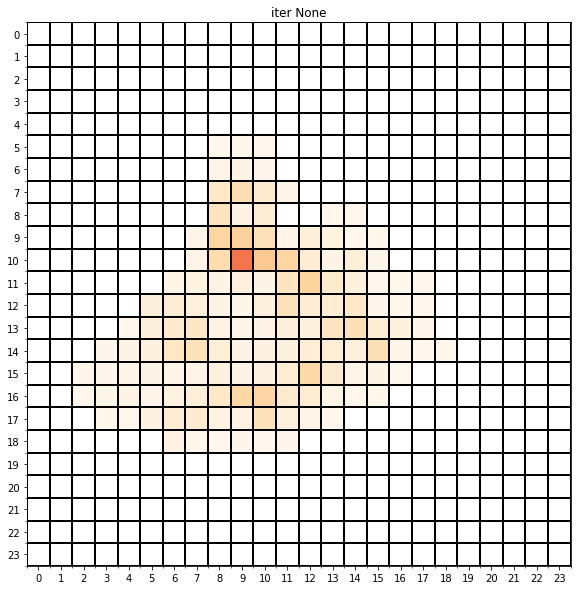

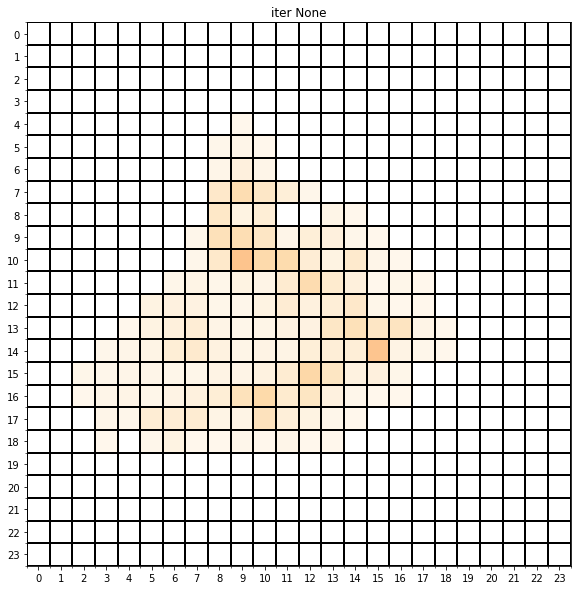

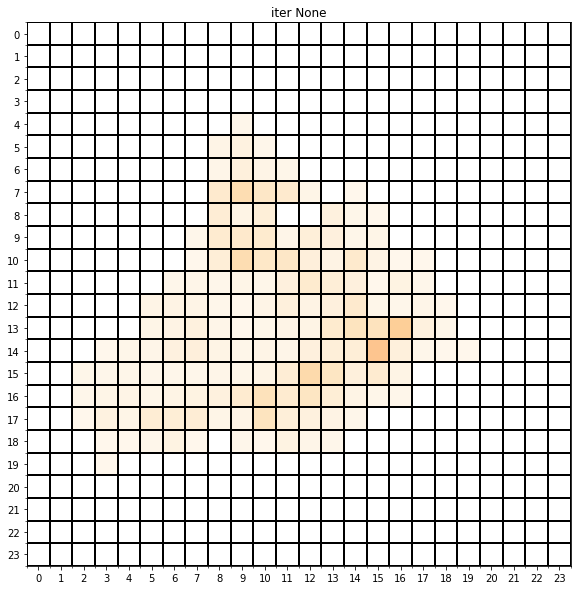

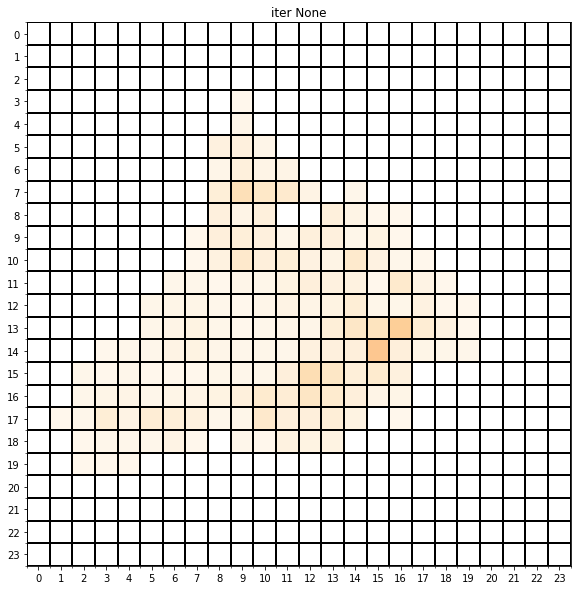

In [8]:
n_iter = 20
for it in range(n_iter):
    cellular_space.update()
    cellular_space.plot(mode = 'sm')